In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import datetime as dt


plt.style.use('seaborn')
sns.set_palette("husl")

/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_95482/186264323.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [58]:
df = pd.read_parquet('../data/oil_and_gas_dataset.parquet')

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556501 entries, 0 to 556500
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   bandeira_revenda_cat  556501 non-null  object        
 1   sigla_uf              556501 non-null  object        
 2   sigla_uf_nome         556501 non-null  object        
 3   id_municipio          556501 non-null  object        
 4   id_municipio_nome     556501 non-null  object        
 5   produto               556501 non-null  object        
 6   unidade_medida        556498 non-null  object        
 7   n_estabelecimentos    556501 non-null  int64         
 8   avg_preco_compra      331360 non-null  float64       
 9   avg_preco_venda       556501 non-null  float64       
 10  data                  556501 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 46.7+ MB


In [60]:
# Check for missing values
print("\nMissing values per column:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})


missing_df[missing_df['Missing Values'] > 0]


Missing values per column:


,Missing Values,Percentage
unidade_medida,3,0.000539
avg_preco_compra,225141,40.456531


## Outliers

In [61]:
def detect_outliers_iqr(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Function to detect outliers using Z-score method
def detect_outliers_zscore(df, column, threshold=3):
    mean = df[column].mean()
    std = df[column].std()
    z_scores = ((df[column] - mean) / std).abs()
    outliers = df[z_scores > threshold]
    return outliers, mean - threshold * std, mean + threshold * std



Extreme values in avg_preco_venda:
Below lower bound (-3.08): 0 (0.00%)
Above upper bound (9.25): 0 (0.00%)


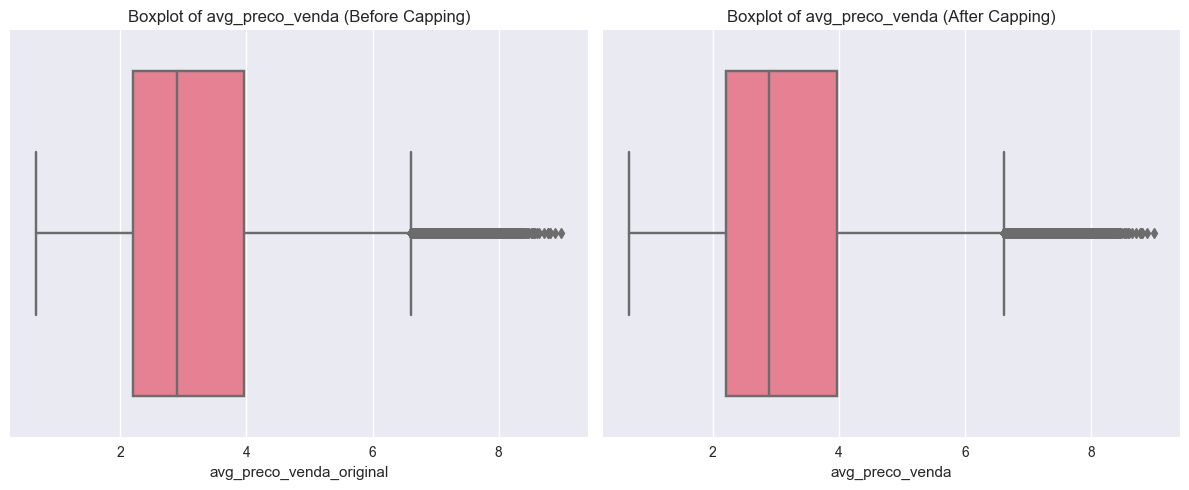

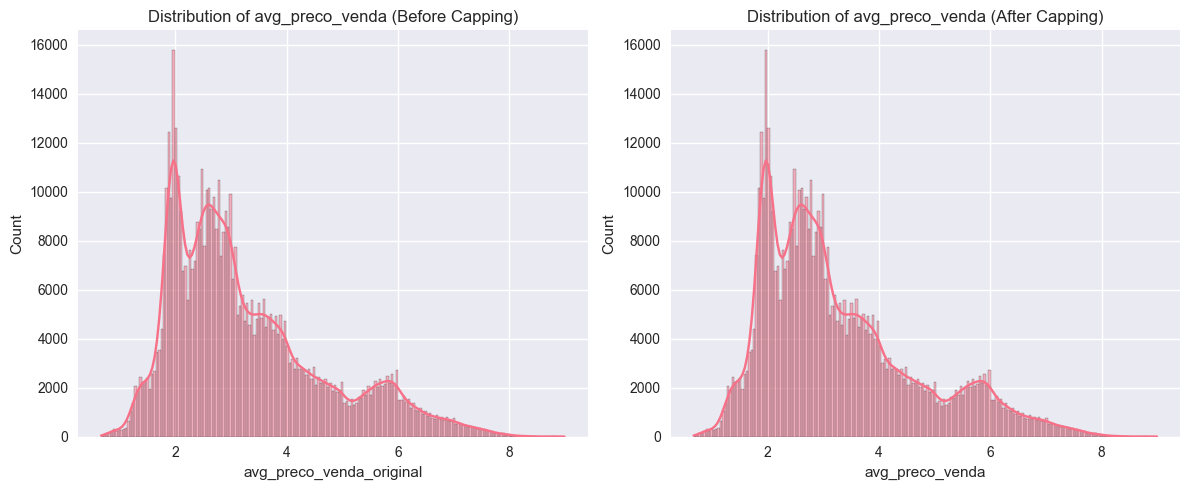


Percentage of values modified by capping: 0.00%

Extreme values in avg_preco_compra:
Below lower bound (-0.06): 0 (0.00%)
Above upper bound (4.46): 491 (0.09%)


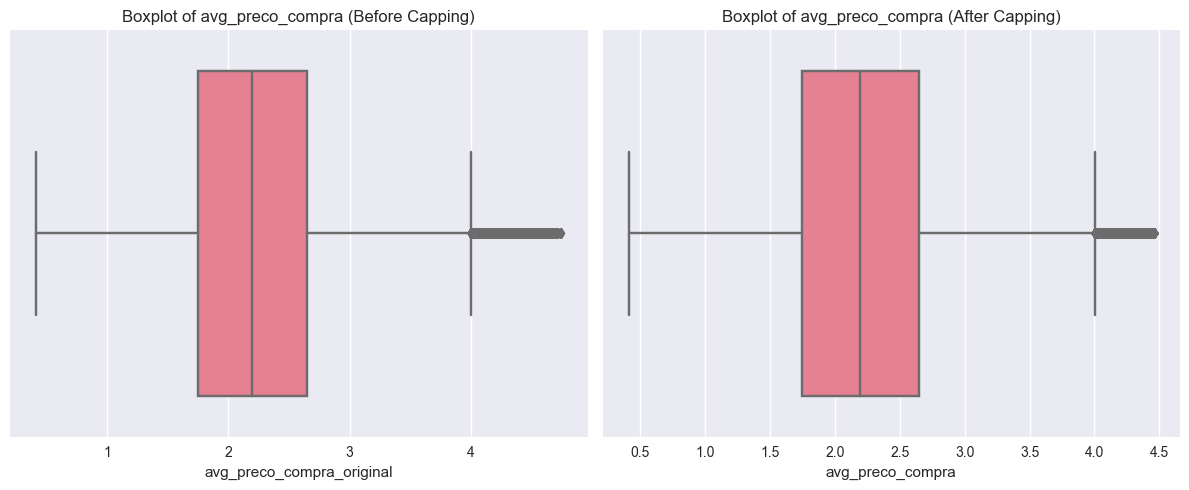


Percentage of values modified by capping: 40.54%

Extreme values in n_estabelecimentos:
Below lower bound (-6.00): 0 (0.00%)
Above upper bound (14.00): 44829 (8.06%)


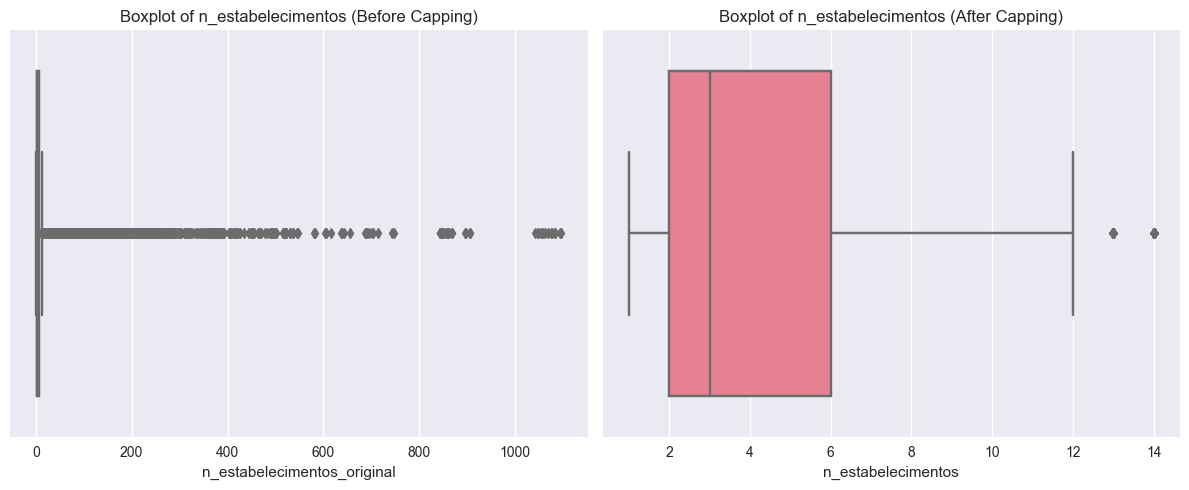


Percentage of values modified by capping: 8.06%


In [62]:
# Handle outliers in the target variable
# We'll use capping (winsorization) for the target variable
if 'avg_preco_venda' in df.columns:
    # Get bounds using IQR method with a more conservative threshold
    _, lower_bound, upper_bound = detect_outliers_iqr(df, 'avg_preco_venda', threshold=3.0)
    
    # Count extreme values
    extreme_low = (df['avg_preco_venda'] < lower_bound).sum()
    extreme_high = (df['avg_preco_venda'] > upper_bound).sum()
    
    print(f"\nExtreme values in avg_preco_venda:")
    print(f"Below lower bound ({lower_bound:.2f}): {extreme_low} ({extreme_low/len(df)*100:.2f}%)")
    print(f"Above upper bound ({upper_bound:.2f}): {extreme_high} ({extreme_high/len(df)*100:.2f}%)")
    
    # Create a copy of the original values for comparison
    df['avg_preco_venda_original'] = df['avg_preco_venda'].copy()
    
    # Apply capping
    df['avg_preco_venda'] = df['avg_preco_venda'].clip(lower=lower_bound, upper=upper_bound)
    
    # Visualize the effect of capping
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df['avg_preco_venda_original'])
    plt.title('Boxplot of avg_preco_venda (Before Capping)')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df['avg_preco_venda'])
    plt.title('Boxplot of avg_preco_venda (After Capping)')
    
    plt.tight_layout()
    plt.show()
    
    # Compare distributions
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df['avg_preco_venda_original'], kde=True)
    plt.title('Distribution of avg_preco_venda (Before Capping)')
    
    plt.subplot(1, 2, 2)
    sns.histplot(df['avg_preco_venda'], kde=True)
    plt.title('Distribution of avg_preco_venda (After Capping)')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate the percentage of modified values
    modified = ((df['avg_preco_venda'] != df['avg_preco_venda_original']).sum() / len(df)) * 100
    print(f"\nPercentage of values modified by capping: {modified:.2f}%")

# Handle outliers in other numerical features
for col in ['avg_preco_compra', 'n_estabelecimentos']:
    if col in df.columns:
        # Get bounds using IQR method
        _, lower_bound, upper_bound = detect_outliers_iqr(df, col, threshold=2.0)
        
        # Count extreme values
        extreme_low = (df[col] < lower_bound).sum()
        extreme_high = (df[col] > upper_bound).sum()
        
        print(f"\nExtreme values in {col}:")
        print(f"Below lower bound ({lower_bound:.2f}): {extreme_low} ({extreme_low/len(df)*100:.2f}%)")
        print(f"Above upper bound ({upper_bound:.2f}): {extreme_high} ({extreme_high/len(df)*100:.2f}%)")
        
        # Create a copy of the original values for comparison
        df[f'{col}_original'] = df[col].copy()
        
        # Apply capping
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
        
        # Visualize the effect of capping
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        sns.boxplot(x=df[f'{col}_original'])
        plt.title(f'Boxplot of {col} (Before Capping)')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col} (After Capping)')
        
        plt.tight_layout()
        plt.show()
        
        # Calculate the percentage of modified values
        modified = ((df[col] != df[f'{col}_original']).sum() / len(df)) * 100
        print(f"\nPercentage of values modified by capping: {modified:.2f}%")



Extreme values in avg_preco_compra:
Below lower bound (-0.06): 0 (0.00%)
Above upper bound (4.46): 0 (0.00%)


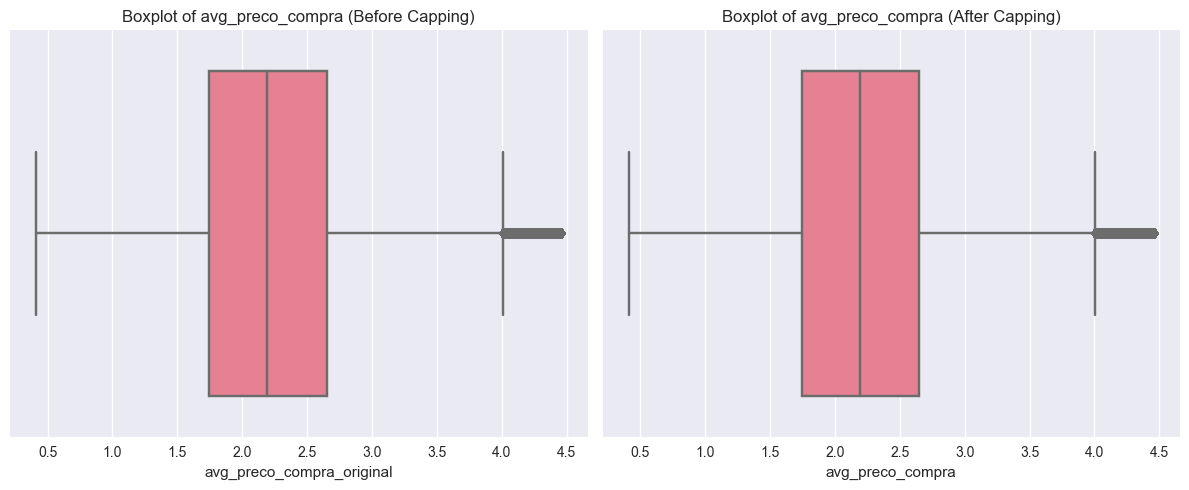


Percentage of values modified by capping: 40.46%

Extreme values in n_estabelecimentos:
Below lower bound (-6.00): 0 (0.00%)
Above upper bound (14.00): 0 (0.00%)


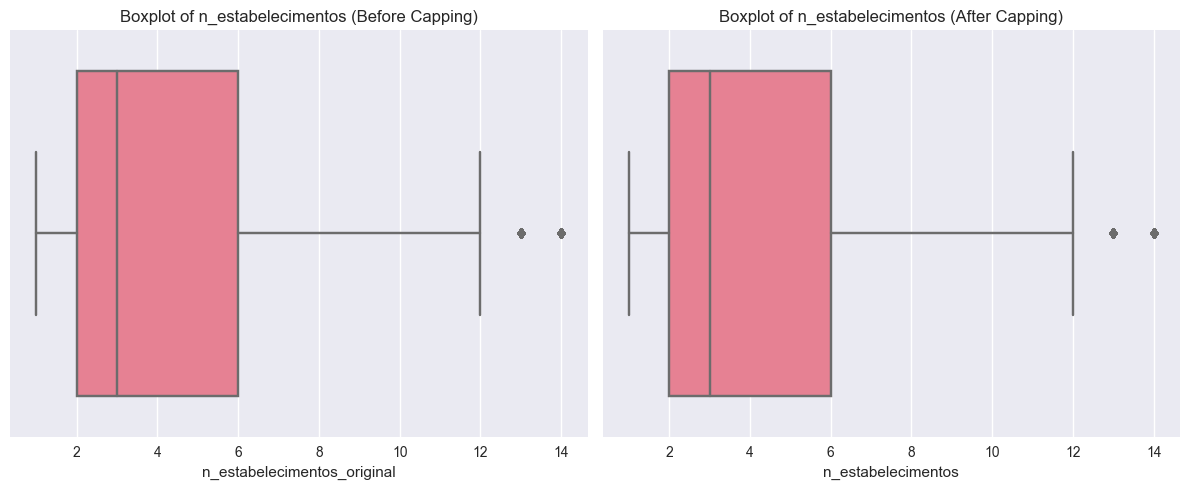


Percentage of values modified by capping: 0.00%


In [63]:
# Handle outliers in other numerical features
for col in ['avg_preco_compra', 'n_estabelecimentos']:
    if col in df.columns:
        # Get bounds using IQR method
        _, lower_bound, upper_bound = detect_outliers_iqr(df, col, threshold=2.0)
        
        # Count extreme values
        extreme_low = (df[col] < lower_bound).sum()
        extreme_high = (df[col] > upper_bound).sum()
        
        print(f"\nExtreme values in {col}:")
        print(f"Below lower bound ({lower_bound:.2f}): {extreme_low} ({extreme_low/len(df)*100:.2f}%)")
        print(f"Above upper bound ({upper_bound:.2f}): {extreme_high} ({extreme_high/len(df)*100:.2f}%)")
        
        # Create a copy of the original values for comparison
        df[f'{col}_original'] = df[col].copy()
        
        # Apply capping
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
        
        # Visualize the effect of capping
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        sns.boxplot(x=df[f'{col}_original'])
        plt.title(f'Boxplot of {col} (Before Capping)')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col} (After Capping)')
        
        plt.tight_layout()
        plt.show()
        
        # Calculate the percentage of modified values
        modified = ((df[col] != df[f'{col}_original']).sum() / len(df)) * 100
        print(f"\nPercentage of values modified by capping: {modified:.2f}%")


In [64]:
# Remove the original columns after analysis
for col in ['avg_preco_venda_original', 'avg_preco_compra_original', 'n_estabelecimentos_original']:
    if col in df.columns:
        df = df.drop(columns=[col])

print("\nOutlier handling completed.")


Outlier handling completed.


## Feature engineering

In [65]:
# 1. Extract temporal features from date
df['year'] = df['data'].dt.year
df['month'] = df['data'].dt.month
df['day'] = df['data'].dt.day
df['day_of_week'] = df['data'].dt.dayofweek
df['quarter'] = df['data'].dt.quarter
df['is_weekend'] = df['data'].dt.dayofweek.isin([5, 6]).astype(int)

In [66]:
# Create price margin feature
df['price_margin'] = df['avg_preco_venda'] - df['avg_preco_compra']
df['price_margin_percent'] = (df['price_margin'] / df['avg_preco_compra']) * 100

# Handle missing values in price_margin_percent (due to missing avg_preco_compra)
df['price_margin_percent'] = df['price_margin_percent'].replace([np.inf, -np.inf], np.nan)

In [67]:
# Handle missing values in price_margin_percent (due to missing avg_preco_compra)
df['price_margin_percent'] = df['price_margin_percent'].replace([np.inf, -np.inf], np.nan)



In [68]:
# Group by location and calculate statistics (excluding target variable)
location_stats = df.groupby(['sigla_uf', 'id_municipio']).agg({
    'n_estabelecimentos': 'mean',
    'avg_preco_compra': ['mean', 'std', 'min', 'max']
}).reset_index()

# Flatten the multi-index columns
location_stats.columns = ['_'.join(col).strip('_') for col in location_stats.columns.values]
# Merge back to the original dataframe
df = pd.merge(
    df, 
    location_stats, 
    on=['sigla_uf', 'id_municipio'], 
    how='left',
    suffixes=('', '_region')
)



In [69]:
#  Group by product and calculate statistics (excluding target variable)
product_stats = df.groupby('produto').agg({
    'avg_preco_compra': ['mean', 'std'],
    'n_estabelecimentos': 'sum'
}).reset_index()

# Flatten the multi-index columns
product_stats.columns = ['_'.join(col).strip('_') for col in product_stats.columns.values]

# Merge back to the original dataframe
df = pd.merge(
    df, 
    product_stats, 
    on='produto', 
    how='left',
    suffixes=('', '_product')
)



In [70]:
#  Group by brand category and calculate statistics (excluding target variable)
brand_stats = df.groupby('bandeira_revenda_cat').agg({
    'avg_preco_compra': ['mean', 'std'],
    'n_estabelecimentos': 'sum'
}).reset_index()

# Flatten the multi-index columns
brand_stats.columns = ['_'.join(col).strip('_') for col in brand_stats.columns.values]

# Merge back to the original dataframe
df = pd.merge(
    df, 
    brand_stats, 
    on='bandeira_revenda_cat', 
    how='left',
    suffixes=('', '_brand')
)



In [ ]:
#  Create time-based lag features (previous month's purchase prices)
df = df.sort_values(['sigla_uf', 'id_municipio', 'produto', 'data'])
df['prev_month_purchase_price'] = df.groupby(['sigla_uf', 'id_municipio', 'produto'])['avg_preco_compra'].shift(1)
df['purchase_price_change'] = df['avg_preco_compra'] - df['prev_month_purchase_price']
df['purchase_price_change_percent'] = (df['purchase_price_change'] / df['prev_month_purchase_price']) * 100

# Handle missing values in purchase_price_change_percent
df['purchase_price_change_percent'] = df['purchase_price_change_percent'].replace([np.inf, -np.inf], np.nan)

In [72]:
# Check the engineered features
print("\nDataset with engineered features:")
df.head()


Dataset with engineered features:


,bandeira_revenda_cat,sigla_uf,sigla_uf_nome,id_municipio,id_municipio_nome,produto,unidade_medida,n_estabelecimentos,avg_preco_compra,avg_preco_venda,...,avg_preco_compra_max,avg_preco_compra_mean_product,avg_preco_compra_std_product,n_estabelecimentos_sum,avg_preco_compra_mean_brand,avg_preco_compra_std_brand,n_estabelecimentos_sum_brand,prev_month_purchase_price,purchase_price_change,purchase_price_change_percent
67666,Blue Label,AC,Acre,1200013,Acrelândia,Diesel,R$/litro,1,1.87405,2.180000,...,2.7861,2.128808,0.552743,728758,2.312183,0.726945,432334,NaN,NaN,NaN
72631,Blue Label,AC,Acre,1200013,Acrelândia,Diesel,R$/litro,1,1.88100,2.180000,...,2.7861,2.128808,0.552743,728758,2.312183,0.726945,432334,1.87405,0.00695,0.370855
75888,Blue Label,AC,Acre,1200013,Acrelândia,Diesel,R$/litro,1,1.88100,2.180000,...,2.7861,2.128808,0.552743,728758,2.312183,0.726945,432334,1.88100,0.00000,0.000000
83684,Blue Label,AC,Acre,1200013,Acrelândia,Diesel,R$/litro,1,1.88100,2.180000,...,2.7861,2.128808,0.552743,728758,2.312183,0.726945,432334,1.88100,0.00000,0.000000
88931,Blue Label,AC,Acre,1200013,Acrelândia,Diesel,R$/litro,1,1.88100,2.386667,...,2.7861,2.128808,0.552743,728758,2.312183,0.726945,432334,1.88100,0.00000,0.000000


## Prepare for modeling

In [73]:
# Define features and target
X = df.drop(['avg_preco_venda'], axis=1)
y = df['avg_preco_venda']

In [74]:
# Define the test set as June, July, and August 2024
test_months = ['2024-06-01', '2024-07-01', '2024-08-01']
test_mask = df['data'].dt.strftime('%Y-%m-%d').isin(test_months)
X_test = X[test_mask]
y_test = y[test_mask]

# Define validation set as April and May 2024
validation_months = ['2024-04-01', '2024-05-01']
validation_mask = df['data'].dt.strftime('%Y-%m-%d').isin(validation_months)
X_val = X[validation_mask]
y_val = y[validation_mask]

# Use the remaining data for training
train_mask = ~(test_mask | validation_mask)
X_train = X[train_mask]
y_train = y[train_mask]

In [75]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Test months: {test_months}")
print(f"Validation months: {validation_months}")

Training set size: 541998
Validation set size: 6389
Test set size: 8114
Test months: ['2024-06-01', '2024-07-01', '2024-08-01']
Validation months: ['2024-04-01', '2024-05-01']


In [76]:
# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
date_features = ['data']

# Remove date column from numeric features if present
if 'data' in numeric_features:
    numeric_features.remove('data')

In [77]:
# Remove features we don't want to use in modeling
features_to_drop = ['sigla_uf_nome', 'id_municipio_nome', 'data']
numeric_features = [f for f in numeric_features if f not in features_to_drop]
categorical_features = [f for f in categorical_features if f not in features_to_drop]

print("\nNumeric features:", numeric_features)
print("\nCategorical features:", categorical_features)




Numeric features: ['n_estabelecimentos', 'avg_preco_compra', 'is_weekend', 'price_margin', 'price_margin_percent', 'n_estabelecimentos_mean', 'avg_preco_compra_mean', 'avg_preco_compra_std', 'avg_preco_compra_min', 'avg_preco_compra_max', 'avg_preco_compra_mean_product', 'avg_preco_compra_std_product', 'n_estabelecimentos_sum', 'avg_preco_compra_mean_brand', 'avg_preco_compra_std_brand', 'n_estabelecimentos_sum_brand', 'prev_month_purchase_price', 'purchase_price_change', 'purchase_price_change_percent']

Categorical features: ['bandeira_revenda_cat', 'sigla_uf', 'id_municipio', 'produto', 'unidade_medida']


In [78]:
# Print missing value information before preprocessing
print("\nMissing values before preprocessing:")
for feature in numeric_features:
    missing_count = X_train[feature].isna().sum()
    if missing_count > 0:
        print(f"  {feature}: {missing_count} missing values ({missing_count/len(X_train)*100:.2f}%)")

for feature in categorical_features:
    missing_count = X_train[feature].isna().sum()
    if missing_count > 0:
        print(f"  {feature}: {missing_count} missing values ({missing_count/len(X_train)*100:.2f}%)")

# Create a copy of the data for imputation
X_train_imputed = X_train.copy()
X_val_imputed = X_val.copy()
X_test_imputed = X_test.copy()

# Impute missing values by state (sigla_uf) for numeric features
for state in X_train['sigla_uf'].unique():
    state_mask = X_train['sigla_uf'] == state
    
    # For each numeric feature, impute with state-specific median
    for feature in numeric_features:
        if X_train[feature].isna().sum() > 0:
            # Calculate the median for this state
            state_median = X_train.loc[state_mask, feature].median()
            
            # If state has no valid values, use global median
            if pd.isna(state_median):
                state_median = X_train[feature].median()
                
            # Impute missing values for this state in train, val, and test sets
            X_train_imputed.loc[X_train_imputed['sigla_uf'] == state, feature] = X_train_imputed.loc[X_train_imputed['sigla_uf'] == state, feature].fillna(state_median)
            X_val_imputed.loc[X_val_imputed['sigla_uf'] == state, feature] = X_val_imputed.loc[X_val_imputed['sigla_uf'] == state, feature].fillna(state_median)
            X_test_imputed.loc[X_test_imputed['sigla_uf'] == state, feature] = X_test_imputed.loc[X_test_imputed['sigla_uf'] == state, feature].fillna(state_median)

# For categorical features, impute with state-specific most frequent value
for state in X_train['sigla_uf'].unique():
    state_mask = X_train['sigla_uf'] == state
    
    for feature in categorical_features:
        if X_train[feature].isna().sum() > 0:
            # Calculate the most frequent value for this state
            state_mode = X_train.loc[state_mask, feature].mode()
            
            # If state has no valid values or no mode, use global mode
            if len(state_mode) == 0:
                state_mode = X_train[feature].mode()
                
            state_mode_value = state_mode[0] if len(state_mode) > 0 else None
            
            # Impute missing values for this state in train, val, and test sets
            X_train_imputed.loc[X_train_imputed['sigla_uf'] == state, feature] = X_train_imputed.loc[X_train_imputed['sigla_uf'] == state, feature].fillna(state_mode_value)
            X_val_imputed.loc[X_val_imputed['sigla_uf'] == state, feature] = X_val_imputed.loc[X_val_imputed['sigla_uf'] == state, feature].fillna(state_mode_value)
            X_test_imputed.loc[X_test_imputed['sigla_uf'] == state, feature] = X_test_imputed.loc[X_test_imputed['sigla_uf'] == state, feature].fillna(state_mode_value)

# Check if any missing values remain and apply global imputation if needed
for feature in numeric_features:
    if X_train_imputed[feature].isna().sum() > 0:
        global_median = X_train[feature].median()
        X_train_imputed[feature] = X_train_imputed[feature].fillna(global_median)
        X_val_imputed[feature] = X_val_imputed[feature].fillna(global_median)
        X_test_imputed[feature] = X_test_imputed[feature].fillna(global_median)

for feature in categorical_features:
    if X_train_imputed[feature].isna().sum() > 0:
        global_mode = X_train[feature].mode()[0]
        X_train_imputed[feature] = X_train_imputed[feature].fillna(global_mode)
        X_val_imputed[feature] = X_val_imputed[feature].fillna(global_mode)
        X_test_imputed[feature] = X_test_imputed[feature].fillna(global_mode)



Missing values before preprocessing:
  avg_preco_compra: 210638 missing values (38.86%)
  price_margin: 210638 missing values (38.86%)
  price_margin_percent: 210638 missing values (38.86%)
  avg_preco_compra_mean: 446 missing values (0.08%)
  avg_preco_compra_std: 446 missing values (0.08%)
  avg_preco_compra_min: 446 missing values (0.08%)
  avg_preco_compra_max: 446 missing values (0.08%)
  prev_month_purchase_price: 210926 missing values (38.92%)
  purchase_price_change: 263325 missing values (48.58%)
  purchase_price_change_percent: 263325 missing values (48.58%)
  unidade_medida: 3 missing values (0.00%)


In [79]:
# Create preprocessing pipelines for scaling (no imputation needed now)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Print missing value information after state-based imputation
print("\nMissing values after state-based imputation:")
for feature in numeric_features:
    missing_count = X_train_imputed[feature].isna().sum()
    if missing_count > 0:
        print(f"  {feature}: {missing_count} missing values ({missing_count/len(X_train_imputed)*100:.2f}%)")

for feature in categorical_features:
    missing_count = X_train_imputed[feature].isna().sum()
    if missing_count > 0:
        print(f"  {feature}: {missing_count} missing values ({missing_count/len(X_train_imputed)*100:.2f}%)")

# Fit the preprocessor on the imputed training data
X_train_processed = preprocessor.fit_transform(X_train_imputed)
X_val_processed = preprocessor.transform(X_val_imputed)
X_test_processed = preprocessor.transform(X_test_imputed)

# Get feature names after preprocessing
onehot_features = []
if categorical_features:
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    onehot_features = onehot_encoder.get_feature_names_out(categorical_features)

feature_names = numeric_features + list(onehot_features)

print(f"\nProcessed feature matrix shape: {X_train_processed.shape}")
print(f"Number of features after preprocessing: {X_train_processed.shape[1]}")
print("All missing values have been handled by state-based imputation and preprocessing")

# Create a dictionary with all the processed data
processed_data = {
    'X_train': X_train_processed,
    'X_val': X_val_processed,
    'X_test': X_test_processed,
    'y_train': y_train.values,
    'y_val': y_val.values,
    'y_test': y_test.values,
    'feature_names': feature_names,
    'preprocessor': preprocessor,
    'X_train_imputed': X_train_imputed,
    'X_val_imputed': X_val_imputed,
    'X_test_imputed': X_test_imputed
}


Missing values after state-based imputation:

Processed feature matrix shape: (541998, 744)
Number of features after preprocessing: 744
All missing values have been handled by state-based imputation and preprocessing


In [80]:
# Save the processed data in a pickle file
import pickle
with open('../data/processed_oil_gas_data.pickle', 'wb') as f:
    pickle.dump(processed_data, f)

In [82]:
X_train = pd.DataFrame(processed_data['X_train'])
X_train.shape

(541998, 744)